In [125]:
import numpy as np


class Options:

    def __init__(self, kilosort_folder, recordings_to_analyse, num_spikes, num_channels, num_samples, fig_folder, temp_folder, last_spikes, borken_channels, fs, verbose):
        self.kilosort_folder = kilosort_folder
        self.recordings_to_analyse = recordings_to_analyse
        self.num_spikes = num_spikes
        self.num_channels = num_channels
        self.num_samples = num_samples
        self.fig_folder = fig_folder
        self.temp_folder = temp_folder
        self.last_spikes = last_spikes
        self.fs = fs
        self.verbose = verbose
        self.borken_channels = borken_channels

        self.waveform_window = np.arange(-self.num_samples / 2, num_samples / 2)


In [174]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')


def load_kilosort_arrays(kilosort_folder, recording, verbose):
    if verbose:
        print('Loading Kilosort arrays: {}\n\n'.format(recording))

    path = os.path.join(kilosort_folder, recording)

    spike_clusters = np.load(os.path.join(path, 'spike_clusters.npy'))
    spike_times = np.load(os.path.join(path, 'spike_times.npy'))
    cluster_groups = pd.read_csv(os.path.join(path, 'cluster_groups.csv'), sep='\t')

    return spike_clusters, spike_times, cluster_groups


def load_raw_data(kilosort_folder, recording, num_channels):
    path = os.path.join(kilosort_folder, recording, recording) + '.dat'
    temp_data = np.memmap(path, dtype=np.int16)
    adjusted_len = int(len(temp_data) / num_channels)  # adjust for number of channels

    raw_data = np.memmap(path, dtype=np.int16, shape=(adjusted_len, num_channels))
    return raw_data


def get_good_cluster_numbers(cluster_groups):
    good_clusters = cluster_groups[cluster_groups['group'] == 'good']
    return good_clusters['cluster_id'].values


def gen_good_spikes_df(spike_times, spike_clusters, good_cluster_numbers):
    all_spikes_df = pd.DataFrame({'spike_time': spike_times.flatten(),
                                  'spike_cluster': spike_clusters.flatten()})
    good_spikes_df = all_spikes_df[all_spikes_df['spike_cluster'].isin(good_cluster_numbers)]
    return good_spikes_df


def gen_spiketimes_series(good_spikes_df, cluster, num_spikes, last_spikes):
    if last_spikes:
        spike_times = good_spikes_df[good_spikes_df['spike_cluster'] == cluster].iloc[-num_spikes:]
    else:
        spike_times = good_spikes_df[good_spikes_df['spike_cluster'] == cluster].iloc[num_spikes:]
    spike_times.index = range(len(spike_times))
    return spike_times


def extract_waveforms(num_spikes, num_samples, num_channels,
                      spike_times, raw_data):
    waveform_window = np.arange(-num_samples / 2, num_samples / 2)
    cols = [''.join(['Chan_', str(num)]) for num in range(0, num_channels)]

    empty_template = np.zeros((num_spikes, num_samples, num_channels))
    for spike in range(num_spikes):
        start_index = int(spike_times['spike_time'].iloc[spike] + waveform_window[0])
        end_index = int((spike_times['spike_time'].iloc[spike] + waveform_window[-1]) + 1)
        waveform = raw_data[start_index:end_index, :]
        empty_template[spike, :, :] = waveform[:, :]

    waveform_per_chan = np.mean(empty_template, axis=0)
    waveform_per_chan = pd.DataFrame(waveform_per_chan, columns=cols)
    return waveform_per_chan


def choose_channel(df, method, broken_chans):
    '''
    Choose either channel with max or minumum values
    method == 'max' or 'min'
    '''
    for chan in broken_chans:
        df.drop('Chan_{}'.format(str(chan)), inplace=True, axis=1)
    if method.lower() == 'max':
        maxes = df.apply(np.max, axis=0)
        selected_chan = df.loc[:, maxes.idxmin()]
    elif method.lower() == 'min':
        mins = df.apply(np.min, axis=0)
        selected_chan = df.loc[:, mins.idxmin()]
    else:
        raise ValueError('Unable to parse channel selection method.\nEnter \'min\' or\'max\'')

    return selected_chan


def gen_peak_finding_df(chan_df):
    df = pd.DataFrame({'y_values': chan_df})
    df['diff'] = df.diff(periods=1)
    df['change'] = (df['diff'] >= 0).map({True: 'increase', False: 'decrease'})
    return df


def calculate_spikewidth(spike_type, fs, **kwargs):
    divisor = int(round(fs / 1000))
    SWs = {'spike_type': spike_type}
    if spike_type == 'up_down_up':
        SWs['SW_peak'] = np.absolute(kwargs['peak_sample'] - kwargs['baseline_sample']) / divisor
        SWs['SW_troff'] = np.absolute(kwargs['min_sample'] - kwargs['baseline_sample']) / divisor
        SWs['SW_return'] = np.absolute(kwargs['return_baseline'] - kwargs['baseline_sample']) / divisor
        SWs['spike_amplitude'] = kwargs['peak_amp'] + np.absolute(kwargs['min_amp'])

    return SWs



In [365]:
def find_baseline_return(df, baseline_amp, min_sample):
    increasing = df.loc[(df['y_values'] < baseline_amp) & (df['change']=='increase') & (df.index > min_sample)]
    
    if (increasing.reset_index().set_index('index', drop=False)['index'].diff() > 1).any():
        last_name = increasing[increasing.reset_index().set_index('index', drop=False)['index'].diff() > 1].iloc[0].name
        increasing = increasing.iloc[:increasing.index.get_loc(last_name)]

    return increasing.iloc[-1].name, increasing.iloc[-1]['y_values']

In [243]:
ops = Options(kilosort_folder=r'C:\Users\Rory\raw_data\CIT_WAY\dat_files\cat',
              recordings_to_analyse=['2018-05-01_01'], 
              num_spikes=1000,
              num_channels=32,
              num_samples=240,
              fig_folder=r'C:\Users\Rory\raw_data\CIT_WAY\figures',
              temp_folder=r'C:\Users\Rory\Documents\Work\temp',
              last_spikes=False,
              fs=30000,
              borken_channels=[6, 22],
             verbose=True)

recording = ops.recordings_to_analyse[0]

In [367]:
def plot_points(df, *args):
    f, a =plt.subplots(figsize=(8,8))
    df['y_values'].plot(ax=a)
    for arg in args:
        x_values = np.ones(2) * arg
        y_values = np.linspace(np.min(df['y_values']), np.max(df['y_values']), 2)
        a.plot(x_values, y_values)
    plt.show()

In [373]:
def up_down_up(df, cluster, num_samples, thresh=0.1, fs=30000):
    half_samples = int(num_samples / 2)

    peak_amp = df['y_values'].iloc[:half_samples].max()
    peak_sample = df['y_values'].iloc[:half_samples].idxmax()

    min_amp = df['y_values'].min()
    min_sample = df['y_values'].idxmin()

    baseline_amp = peak_amp * thresh
    baseline_sample = df.loc[(df['y_values'] < peak_amp)
                             & (df.index < peak_sample)
                             & (df['change'] == 'increase')
                             & (df['y_values'] >= baseline_amp), 'y_values'].idxmin()
    return_sample, return_amp = find_baseline_return(df, baseline_amp, min_sample)
    
    SWs = calculate_spikewidth(spike_type='up_down_up',
                               fs=30000,
                               peak_sample=peak_sample,
                               baseline_sample=baseline_sample,
                               min_sample=min_sample,
                               peak_amp=peak_amp,
                               return_baseline=return_sample,
                               min_amp=min_amp)
    return SWs

In [ ]:
def down_up(df, num_samples):
    half_samples = int(num_samples / 2)

    min_amp = df['y_values'].min()
    min_sample = df['y_values'].idxmin()

    baseline_amp = np.mean(df['y_values'].iloc[:int(ops.num_samples/2)])
    baseline_sample = df.loc[(df['y_values'] > min_amp)
                            & (df['y_values'] < baseline_amp)
                            & (df.index < min_sample)
                        & (df['change']=='decrease'), 'y_values'].idxmax()
    return_sample, return_amp = find_baseline_return(df, baseline_amp, min_sample)
    
    SWs = calculate_spikewidth(spike_type='up_down_up',
                            fs=30000,
                               peak_sample=peak_sample,
                               baseline_sample=baseline_sample,
                               min_sample=min_sample,
                               peak_amp=peak_amp,
                               return_baseline=return_sample,
                               min_amp=min_amp)

In [244]:
spike_clusters, spike_times, cluster_groups = load_kilosort_arrays(kilosort_folder=ops.kilosort_folder,
                                                                  recording=recording,
                                                                  verbose=ops.verbose)
raw_data = load_raw_data(kilosort_folder=ops.kilosort_folder,
                        recording=recording,
                        num_channels=ops.num_channels)

good_cluster_numbers = get_good_cluster_numbers(cluster_groups)
good_spikes_df = gen_good_spikes_df(spike_times=spike_times,
                                    spike_clusters=spike_clusters,
                                    good_cluster_numbers=good_cluster_numbers)

Loading Kilosort arrays: 2018-05-01_01




In [270]:
good_cluster_numbers

array([  0,   4,   6,   9,  13,  16,  17,  22,  24,  26,  27,  31,  32,
        33,  51,  57,  59,  71,  73,  74,  83,  97,  98,  99, 103, 112,
       113, 116, 119], dtype=int64)

In [461]:
cluster = good_cluster_numbers[27]

In [462]:
spiketimes_series = gen_spiketimes_series(good_spikes_df=good_spikes_df,
                                          cluster=cluster,
                                          num_spikes=ops.num_spikes,
                                          last_spikes=ops.last_spikes)
waveform_per_chan = extract_waveforms(num_spikes=ops.num_spikes,
                                      num_samples=ops.num_samples,
                                      num_channels=ops.num_channels,
                                      spike_times=spiketimes_series,
                                      raw_data=raw_data)

df = choose_channel(df=waveform_per_chan, method='min', broken_chans=ops.borken_channels)
df = gen_peak_finding_df(chan_df=df)

116


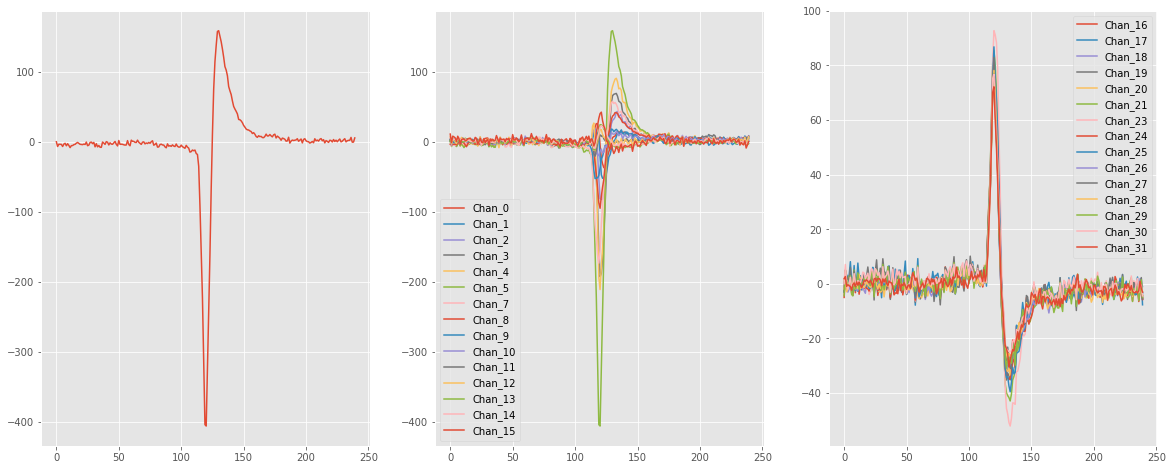

In [463]:
f, a = plt.subplots(nrows=1, ncols=3, figsize=(20,8))
waveform_per_chan.iloc[:, :15].plot(ax=a[1])
waveform_per_chan.iloc[:, 15:].plot(ax=a[2])
df['y_values'].plot(ax=a[0])
print(cluster)

In [464]:
presence_of_initial_peak = (df['y_values'].iloc[:int(ops.num_samples/2)] > 30).any()
if presence_of_initial_peak:
    x = up_down_up(df, cluster, ops.num_samples, thresh=0.1, fs=30000)

In [465]:
np.median(df['y_values'].iloc[:int(ops.num_samples/4)])

-3.718

In [466]:
def down_up(df, num_samples):
    half_samples = int(num_samples / 2)

    min_amp = df['y_values'].min()
    min_sample = df['y_values'].idxmin()

    baseline_amp = np.mean(df['y_values'].iloc[:int(ops.num_samples/2)])
    baseline_sample = df.loc[(df['y_values'] > min_amp)
                            & (df['y_values'] < baseline_amp)
                            & (df.index < min_sample)
                        & (df['change']=='decrease'), 'y_values'].idxmax()

    return_sample, return_amp = find_baseline_return(df, baseline_amp, min_sample)

In [467]:
baseline_amp = np.mean(df['y_values'].iloc[:int(ops.num_samples/2)])

baseline_sample = df.loc[(df['y_values'] > min_amp)
                        & (df['y_values'] < baseline_amp)
                        & (df.index < min_sample)
                    & (df['change']=='decrease'), 'y_values'].idxmax()

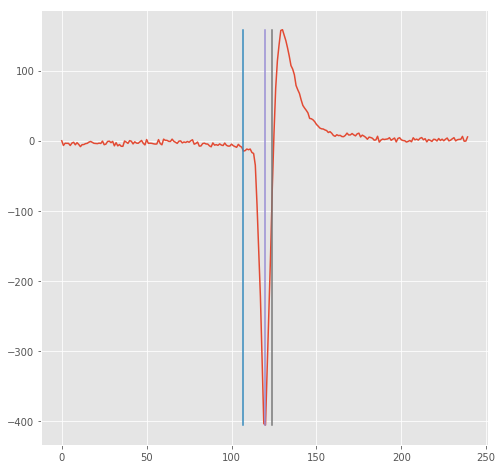

In [468]:
plot_points(df, baseline_sample, min_sample, return_sample)

In [ ]:
baseline_sample = df.loc[(df['y_values'] > min_amp)
                          & (df['y_values'] < baseline_amp)
                          & (df.index < min_sample)
                          & (df['change']=='decrease'), 'y_values'].idxmin() - 10

In [400]:
baseline_amp = min_amp * thresh

In [398]:
min_amp * thresh

-74.285000000000011

In [402]:
df.loc[(df['y_values'] > min_amp)
      & (df['y_values'] < baseline_amp)
      & (df.index < min_sample)
      & (df['change']=='decrease'), 'y_values'].idxmin()

118

In [396]:
baseline_amp

13.807200000000002

In [ ]:
def find_baseline_sample(df, baseline_amp, min_sample, rev=False):
    increasing = df.loc[(df['y_values'] < baseline_amp) & (df['change']=='increase') & (df.index > min_sample)]
    
    if (increasing.reset_index().set_index('index', drop=False)['index'].diff() > 1).any():
        last_name = increasing[increasing.reset_index().set_index('index', drop=False)['index'].diff() > 1].iloc[0].name
        increasing = increasing.iloc[:increasing.index.get_loc(last_name)]

    return increasing.iloc[-1].name, increasing.iloc[-1]['y_values']

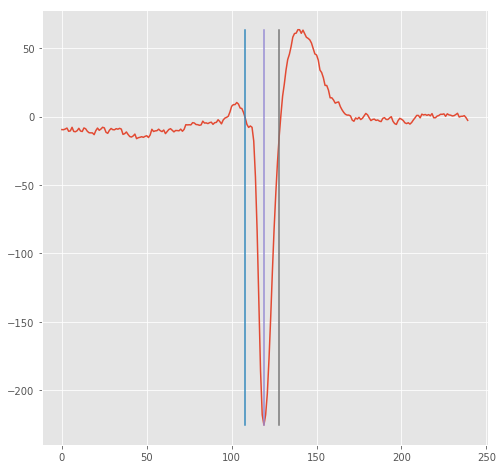

In [410]:
plot_points(df, baseline_sample, min_sample, return_sample)

In [472]:
df1 = pd.DataFrame(x, index=[0])

In [473]:
df1

,spike_type,SW_peak,SW_troff,SW_return,spike_amplitude
0,up_down_up,0.1,0.4,0.966667,300.896


In [477]:
x1 = {k:'hello' for k, value in x.items()}

In [478]:
df2 = pd.DataFrame(x1, index=[0])

In [479]:
df_list = [df1, df2]

In [482]:
df3 = pd.concat(df_list)

In [486]:
df3.index = range(len(df3))

In [487]:
df3.set_index()

,spike_type,SW_peak,SW_troff,SW_return,spike_amplitude
0,up_down_up,0.1,0.4,0.966667,300.896
1,hello,hello,hello,hello,hello


In [490]:
def deffer(*args, x, y, z):
    print(x)
    print(y)
    print(z)
    for arg in args:
        print('ooo {}'.format(arg))

In [491]:
deffer('te', 'hi', x=2, y=6, z=20)

2
6
20
ooo te
ooo hi


In [ ]:
df3.to_csv()